In [97]:
# Disable warnings in Anaconda
import warnings

from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8

def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

data_path = '../mlcourse.ai_Dataset/'

data = pd.read_csv(data_path + 'credit_scoring_sample.csv')

In [98]:
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Distribution of the target:


SeriousDlqin2yrs
0    0.777511
1    0.222489
Name: proportion, dtype: float64

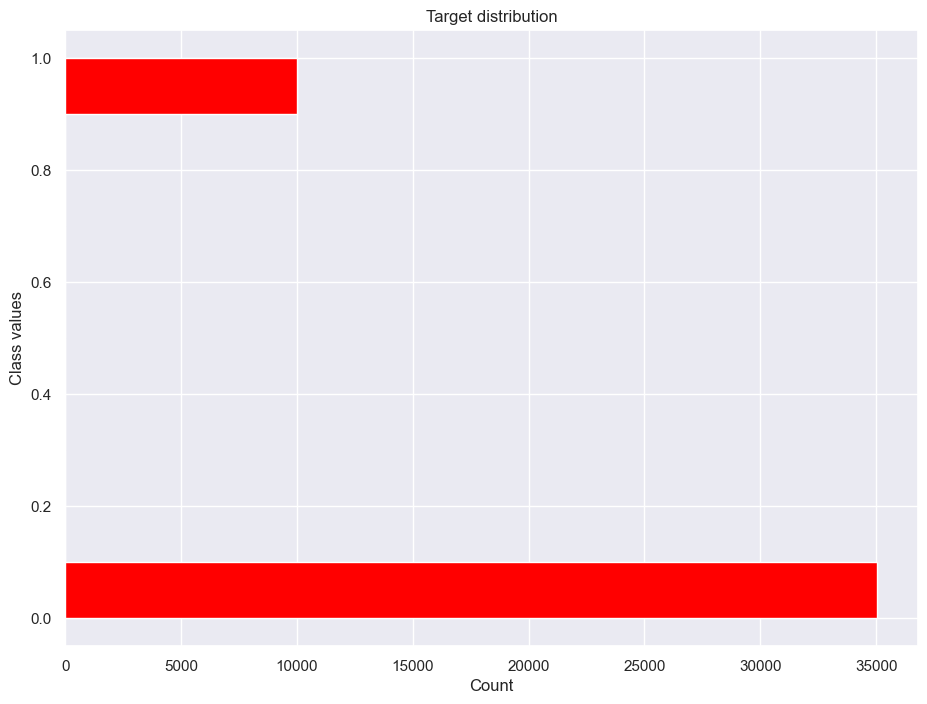

In [99]:
ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")
ax.set_xlabel("Count")
ax.set_ylabel("Class values")
ax.set_title("Target distribution")

print("Distribution of the target:")
data["SeriousDlqin2yrs"].value_counts(normalize=True)

In [100]:
independent_column_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_column_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [101]:
data = fill_nan(data)

In [102]:
X = data[independent_column_names]
y = data["SeriousDlqin2yrs"]

In [103]:
def get_bootstrap_samples(data, n_samples):
    """Generate samples using bootstrapping."""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    """Produce an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2.0, 100 * (1 - alpha / 2.0)])
    return boundaries

delayed_age = data[data["SeriousDlqin2yrs"] == 1]["age"].values
np.random.seed(0)
delayed_age_mean_score = [np.mean(sample) for sample in get_bootstrap_samples(delayed_age, 10000)]
print(f'Average age of customers who delayed repayment: {stat_intervals(delayed_age_mean_score, 0.1)}')

Average age of customers who delayed repayment: [45.71224317 46.13924297]


In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

lr = LogisticRegression(random_state=5, class_weight="balanced")
parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

lr_grid_search = GridSearchCV(lr, parameters, cv=skf, scoring='roc_auc')

lr_grid_search.fit(X, y)

print(f'Best parameter score: {lr_grid_search.best_params_} with ROC AUC score of {lr_grid_search.best_score_}')

Best parameter score: {'C': 0.001} with ROC AUC score of 0.8089120626797153


In [105]:
print(lr_grid_search.cv_results_['std_test_score'])

[0.00729192 0.00813756 0.00795436 0.00515991 0.00747165 0.00517587]


The model is not stable, since its standard deviation is more than 0.5%

In [106]:
from sklearn.preprocessing import StandardScaler

lr = LogisticRegression(random_state=5, class_weight="balanced", C=0.001)
scaler = StandardScaler()
lr.fit(scaler.fit_transform(X),y)

lr_coef_df = pd.DataFrame(lr.coef_.T, columns=['Coefficient'], index=independent_column_names)
abs_lr_coef_df = lr_coef_df.abs()
abs_lr_coef_df.sort_values(by='Coefficient', ascending=False)

,Coefficient
NumberOfTime30-59DaysPastDueNotWorse,0.723427
NumberOfTimes90DaysLate,0.516788
age,0.416702
NumberOfTime60-89DaysPastDueNotWorse,0.193558
MonthlyIncome,0.163146
NumberOfDependents,0.101443
DebtRatio,0.024096


In [107]:
lr_coef_df.index

Index(['age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse',
       'MonthlyIncome', 'NumberOfDependents'],
      dtype='object')

In [108]:
### Question 6
indexes = ['age', 'NumberOfTime30-59DaysPastDueNotWorse',
           'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse',
           'MonthlyIncome', 'NumberOfDependents']
print(np.exp(lr_coef_df.loc['DebtRatio']['Coefficient'])/sum(np.exp(lr_coef_df.loc[indexes]['Coefficient'])))

0.1290042641879216


In [109]:
### Question 7
log_regr = LogisticRegression(random_state=5, class_weight="balanced", C=0.001)
log_regr.fit(X, y)

lr_coef_df = pd.DataFrame(lr.coef_.T, columns=['Coefficient'], index=independent_column_names)
lr_coef_df

,Coefficient
age,-0.416702
NumberOfTime30-59DaysPastDueNotWorse,0.723427
DebtRatio,-0.024096
NumberOfTimes90DaysLate,0.516788
NumberOfTime60-89DaysPastDueNotWorse,0.193558
MonthlyIncome,-0.163146
NumberOfDependents,0.101443


In [110]:
np.exp(lr_coef_df.loc['age']['Coefficient'] * 20)

0.00024019826344027129

In [111]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, class_weight="balanced")

parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

rf_grid = GridSearchCV(estimator=rf, param_grid=parameters, scoring='roc_auc', cv=skf, verbose=1)

In [112]:
rf_grid.fit(X,y)

print(rf_grid.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=3; total time=   0.5s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=3; total time=   0.8s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=3; total time=   0.5s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=3; total time=   0.4s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=3; total time=   0.4s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=5; total time=   0.4s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=5; total time=   0.4s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=5; total time=   0.4s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=5; total time=   0.4s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=5; total time=   0.5s
[CV] END ....max_depth=5, max_features=1, min_samples_leaf=7; total time=   0.4s
[CV] END ....max_depth=5, max_features=1, min_s

In [113]:
print(rf_grid.best_score_- lr_grid_search.best_score_)

0.026866475306627002


In [114]:
print(rf_grid.best_params_)

{'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 9}


In [131]:
rf = RandomForestClassifier(max_features=2, min_samples_leaf=9, max_depth=10)
rf.fit(X, y)
# rf_coef_df = pd.DataFrame(rf.coef_.T, columns=['Coefficient'], index=independent_column_names)
# rf_coef_df

RandomForestClassifier(max_depth=10, max_features=2, min_samples_leaf=9)

In [136]:
print(independent_column_names[np.argmin(rf.feature_importances_)])

NumberOfDependents


In [138]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

parameters = {
    "max_features": [2, 3, 4],
    "max_samples": [0.5, 0.7, 0.9],
    "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100],
}

bagging = BaggingClassifier(LogisticRegression(class_weight="balanced"), n_estimators=100, n_jobs=-1, random_state=42)

bagging_cv = RandomizedSearchCV(estimator=bagging, param_distributions=parameters, cv=skf, verbose=1, scoring='roc_auc', n_iter=20)

bagging_cv.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
                   estimator=BaggingClassifier(estimator=LogisticRegression(class_weight='balanced'),
                                               n_estimators=100, n_jobs=-1,
                                               random_state=42),
                   n_iter=20,
                   param_distributions={'base_estimator__C': [0.0001, 0.001,
                                                              0.01, 1, 10,
                                                              100],
                                        'max_features': [2, 3, 4],
                                        'max_samples': [0.5, 0.7, 0.9]},
                   scoring='roc_auc', verbose=1)

In [139]:
bagging_cv.best_score_

0.8087951623513827

In [140]:
bagging_cv.best_params_

{'max_samples': 0.9, 'max_features': 2, 'base_estimator__C': 100}